# Bootstrapping Variability into Trends and Mass Transport

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import glob
from zipfile import ZipFile
import gsw
import pandas as pd
import geopandas
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import time
import datetime
from scipy.stats import linregress
from scipy.stats import t
import scipy.stats as stats
import cmocean.cm as cmo
from erddapy import ERDDAP
import matplotlib.gridspec as gridspec
import cartopy
import geopy.distance
from scipy.interpolate import interp1d
import scipy
import statsmodels.api as sm
from pyproj import Geod
import random

rho_Cp =  4.1 * (10**6) ## From Johns et al. (2011) [J/(kg*C)]


## Functions

In [2]:
def calculate_confidence_interval(slope, standard_error, confidence_level=0.95, df=None):
    if df is None:
        # For large samples, use the normal distribution
        t_critical = stats.norm.ppf((1 + confidence_level) / 2)
    else:
        # Use the t-distribution for smaller samples
        t_critical = stats.t.ppf((1 + confidence_level) / 2, df)
    
    margin_of_error = t_critical * standard_error
    confidence_interval = (slope - margin_of_error, slope + margin_of_error)
    
    return confidence_interval


def random_val_between_neg_and_pos_input(x):
    return random.uniform(-x, x)

def subset(ds,lon_min,lon_max,lat_min,lat_max):
    ## profiles that fulfill the lat/lon ranges
    ind = np.where((ds.LONGITUDE>=lon_min) & (ds.LONGITUDE<=lon_max) &
                   (ds.LATITUDE>=lat_min)  & (ds.LATITUDE<=lat_max))[0]
    ## subset
    subset_ds = xr.merge([ds.PSAL_CORRECTED[ind,:],
                      ds.POTM_CORRECTED[ind,:],
                      ds.DEPH_CORRECTED[ind,:],
                      ds.POSITION_QC[ind],
                      ds.PROFILE_POTM_QC[ind],
                      ds.PROFILE_PSAL_QC[ind],
                      ds.POTM_CORRECTED_QC[ind],
                      ds.PSAL_CORRECTED_QC[ind],
                      ds.INST_REFERENCE[ind],
                      ds.JULD[ind],
                      ds.LONGITUDE[ind],
                      ds.LATITUDE[ind],
                     ],combine_attrs='drop')
    return subset_ds




def qaqc(ds):
    ## Pull out profiles that fail check
    position_qc_ind = np.where(ds.POSITION_QC == b'4')[0]
    profile_potm_qc_ind = np.where(ds.PROFILE_POTM_QC == b'4')[0]
    profile_psal_qc_ind = np.where(ds.PROFILE_PSAL_QC == b'4')[0]
    potm_corrected_qc_ind = np.where(ds.POTM_CORRECTED_QC == b'4')[0]
    psal_corrected_qc_ind = np.where(ds.PSAL_CORRECTED_QC == b'4')[0]
    ## Combine indicies
    tot_qc_ind = np.unique(np.concatenate([position_qc_ind,profile_potm_qc_ind,profile_psal_qc_ind,potm_corrected_qc_ind,psal_corrected_qc_ind]))
    ## Remove from dataset
    ds.PSAL_CORRECTED[tot_qc_ind,:] = np.nan
    ds.POTM_CORRECTED[tot_qc_ind,:] = np.nan
    return ds




def gsw_convert(ds):
    
    lats = np.tile(ds.LATITUDE,(len(ds.N_LEVELS),1)).transpose()
    lons = np.tile(ds.LONGITUDE,(len(ds.N_LEVELS),1)).transpose()
    pressure = gsw.p_from_z(-ds.DEPH_CORRECTED, lats, geo_strf_dyn_height=0, sea_surface_geopotential=0)

    ds['absolute_salinity'] = gsw.SA_from_SP(ds.PSAL_CORRECTED, pressure, lons, lats)    
    ds['conservative_temperature'] = gsw.CT_from_pt(ds.absolute_salinity, ds.POTM_CORRECTED)
    
    return ds





def depth_grid(ds):
    ########################################################################################################################
    #### Depth grid interpolation
    depth_grid = np.concatenate([np.arange(0,101,5),np.arange(125,251,25),np.arange(300,1501,50),np.arange(1550,7000,250)])

    temp_interp = np.empty((len(depth_grid),ds.conservative_temperature.shape[1]))
    salt_interp = np.empty((len(depth_grid),ds.conservative_temperature.shape[1]))
    

    for x in np.arange(0,ds.conservative_temperature.shape[1]):
        temp_interp[:,x] = np.interp(depth_grid, ds.DEPH_CORRECTED.values[:,x], ds.conservative_temperature[:,x], left=np.nan, right=np.nan)
        salt_interp[:,x] = np.interp(depth_grid, ds.DEPH_CORRECTED.values[:,x], ds.absolute_salinity[:,x], left=np.nan, right=np.nan)
    ########################################################################################################################

    ## Check which profiles are NOT all nans
    non_nan_ind = np.where(np.sum(np.isnan(salt_interp),axis=0)!=len(depth_grid))[0]

    new_ds = xr.Dataset(
        data_vars=dict(
            conservative_temperature = (["depth", "time"], temp_interp[:,non_nan_ind]),
            absolute_salinity        = (["depth", "time"], salt_interp[:,non_nan_ind]),
            longitude                = (["time"], ds.LONGITUDE.values[non_nan_ind]),
            latitude                 = (["time"], ds.LATITUDE.values[non_nan_ind]),
            obs_type                 = (["time"], ds.INST_REFERENCE.values[non_nan_ind]))
            ,
        coords=dict(
            depth = depth_grid,
            time  = ds.JULD.values[non_nan_ind]))
    
    new_ds = new_ds.sortby('time')

    return new_ds








def spatial_grid(ds,lon_step,time=None):

    ########################################################################################################################
    #### Spatial grid
    # lon_step = 0.5 # degrees
    # lat_step = 0.5 # degrees

    ## Went larger than shapefile and then clip will trim
    lon_gridt = np.arange(-77.5,-17,lon_step)
    lat_max = 23    # started with 23
    lat_min = 20    # started with 20
    #lat_gridt = np.arange(21,24,lat_step)

    ## Lat/Lon grid mid points
    mid_lons = lon_gridt+(lon_step/2)
    #mid_lats = lat_gridt+(lat_step/2)

    ## For total anomaly
    if time == None:
        ## Preallocate
        grid_temp     = np.empty((len(ds.depth), len(lon_gridt),1))
        grid_temp[:]  = np.nan
        grid_salt     = np.empty((len(ds.depth), len(lon_gridt),1))
        grid_salt[:]  = np.nan
        grid_count    = np.empty(len(lon_gridt),1)
        grid_count[:] = np.nan
        
        ## Stuff data in the grid cells!
        for x in np.arange(0,len(lon_gridt)-1):
            #for y in np.arange(0,len(lat_gridt)-1):
            grid_ind = np.where((ds.longitude.values >= lon_gridt[x])   & 
                                    (ds.longitude.values <= lon_gridt[x+1]) &
                                    (ds.latitude.values  >= lat_min)   &
                                    (ds.latitude.values  <= lat_max))[0]

            grid_temp[:,x,0] = ds.conservative_temperature[:,grid_ind].mean(axis=1)
            grid_salt[:,x,0] = ds.absolute_salinity[:,grid_ind].mean(axis=1)
            grid_count[x,0]  = len(grid_ind)
    
        ### Make a new gridded dataset
        grid_ds = xr.Dataset(
            data_vars=dict(
                conservative_temperature=(["depth", "longitude","latitude"], grid_temp),
                absolute_salinity=(["depth", "longitude","latitude"], grid_salt),
                num_profs = (["latitude","longitude","latitude"],grid_count),
            ),
            coords=dict(
                longitude=mid_lons,
                latitude=np.atleast_1d(21.5),
                depth=ds.depth.values,
            ))
    ## Because adding time dimension
    else:
        # ## Preallocate
        # grid_temp     = np.empty((len(ds.depth), len(lat_gridt), len(lon_gridt),1))
        # grid_temp[:]  = np.nan
        # grid_salt     = np.empty((len(ds.depth), len(lat_gridt), len(lon_gridt),1))
        # grid_salt[:]  = np.nan
        # grid_count    = np.empty((len(lat_gridt), len(lon_gridt),1))
        # grid_count[:] = np.nan
        ## Preallocate
        grid_temp     = np.empty((len(ds.depth), len(lon_gridt),1,1))
        grid_temp[:]  = np.nan
        grid_salt     = np.empty((len(ds.depth), len(lon_gridt),1,1))
        grid_salt[:]  = np.nan
        grid_count    = np.empty((len(lon_gridt),1,1))
        grid_count[:] = np.nan
        
        ## Stuff data in the grid cells!
        for x in np.arange(0,len(lon_gridt)-1):
            grid_ind = np.where((ds.longitude.values >= lon_gridt[x])   & 
                                    (ds.longitude.values <= lon_gridt[x+1]) &
                                    (ds.latitude.values  >= lat_min)   &
                                    (ds.latitude.values  <= lat_max))[0]
                
            grid_temp[:,x,0,0] = ds.conservative_temperature[:,grid_ind].mean(axis=1)
            grid_salt[:,x,0,0] = ds.absolute_salinity[:,grid_ind].mean(axis=1)
            grid_count[x,0,0]  = len(grid_ind)
    
        
        
        ### Make a new gridded dataset
        grid_ds = xr.Dataset(
            data_vars=dict(
                conservative_temperature=(["depth", "longitude","latitude","time"], grid_temp),
                absolute_salinity=(["depth", "longitude","latitude","time"], grid_salt),
                num_profs = (["longitude","latitude","time"],grid_count),
            ),
            coords=dict(
                longitude=mid_lons,
                latitude=np.atleast_1d(21.5),
                depth=ds.depth.values,
                time=np.atleast_1d(pd.to_datetime(time)),
            ))

    return grid_ds


geodesic = Geod(ellps="WGS84")  # define the coordinate system. WGS84 is the standard used by GPS.
def calculate_transect(start, end, dist=5000):
    from pyproj import Geod
    g = Geod(ellps="WGS84")
    
    pts = g.inv_intermediate(start[0], start[1], end[0], end[1], 0, dist) 
    _, _, dist = g.inv(np.full(len(pts.lons), start[0]), np.full(len(pts.lons), start[1]), pts.lons, pts.lats)
    return np.column_stack([pts.lons, pts.lats]), dist


def reckon(origin_lon, origin_lat, forward_azimuth, distance):
    """
    Calculate lon, lat of a point from a specified azimuth, distance on sphere or ellipsoid
    Helper function for pyproj.Geod forward transformation

    Args:
        origin_lon (array, numpy.ndarray, list, tuple, or scalar):
            Longitude(s) of initial point(s)
        origin_lat (array, numpy.ndarray, list, tuple, or scalar):
            Latitude(s) of initial point(s)
        forward_azimuth (array, numpy.ndarray, list, tuple, or scalar):
            Azimuth/bearing(s) of the terminus point relative to the initial point(s)
        distance (array, numpy.ndarray, list, tuple, or scalar):
            Distance(s) between initial and terminus point(s) in kilometers

    Returns:
        array, numpy.ndarray, list, tuple, or scalar: Longitude(s) of terminus point(s)
        array, numpy.ndarray, list, tuple, or scalar: Latitude(s) of terminus point(s)
        array, numpy.ndarray, list, tuple, or scalar: Backwards azimuth(s) of terminus point(s)
    """
    terminus_lon, terminus_lat, _ = geodesic.fwd(origin_lon, origin_lat, forward_azimuth, distance * 1000)
    return terminus_lon, terminus_lat

  

## First figure out the clip-zone

/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(-90.0, -15.0)

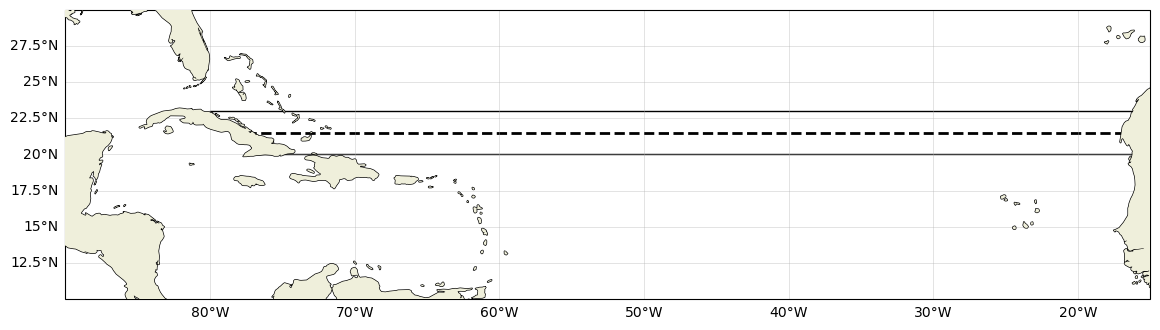

In [3]:
fig, ax = plt.subplots(figsize=(14,12),subplot_kw=dict(projection=cartopy.crs.PlateCarree()))

plt.plot([-80, -16], [23, 23],'k', linewidth=1,transform=cartopy.crs.PlateCarree())
plt.plot([-77.5, -16], [21.5, 21.5],'k--', linewidth=2,transform=cartopy.crs.PlateCarree())
plt.plot([-77.5, -16], [20, 20],'k', linewidth=1,transform=cartopy.crs.PlateCarree())


ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
ax.set_ylim(10,30)
ax.set_xlim(-90,-15)

# Pre-Processing Step 1:

**This does the following, looping through each file which represents all the data from a month in a year:**
1) Loads data
2) Subsets to box
3) QAQC
4) Depth grid interpolation
5) Save output

This takes ~8 minutes

In [4]:
# # Record the start time
# start_time = time.time()
# print("Start time:", datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S'))


# ## Extracted file name
# fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/extracted/*.nc')

# for x in np.arange(0,len(fnames)):
#     ds = xr.open_dataset(fnames[x])

#     subset_ds = subset(ds,lon_min = -79,
#                       lon_max = -16,
#                       lat_min = 21,
#                       lat_max = 23)

#     subset_ds = qaqc(subset_ds)

#     ## Check if there is data after the QAQC
#     if len(subset_ds.N_PROF)==0:
#          continue
#     else:
#         ## Convert to absolute salinity and conservative temperature
#         subset_ds = gsw_convert(subset_ds)
#         ## Transpose to make dimensions make more sense
#         subset_ds = subset_ds.transpose()
#         ## Convert time here
#         subset_ds.JULD.values = pd.to_datetime(subset_ds.JULD)
#         ## Save
#         year = subset_ds.JULD.dt.year.values[0]
#         month = subset_ds.JULD.dt.month.values[0]
#         if len(str(month)) == 1:
#             month = '%02d' % month ## Make 2 digit month if it is only a 1 digit month (i.e. turn 3 into 03 for March)
    
#         ## Do the depth grid interpolation!!
#         subset_ds = depth_grid(subset_ds)   
    
#         ## Save
#         directory_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/Processed_ATL/'
#         save_file_name = ''.join([directory_name,"EN4_ATL_",str(year),str(month),".nc"])
#         subset_ds.to_netcdf(save_file_name)
    
    
# # Record the end time
# end_time = time.time()

# # Calculate the elapsed time
# elapsed_time = end_time - start_time

# # Print the elapsed time in seconds
# print(f"Elapsed time: {elapsed_time} seconds")



# Pre-Processing Step 2:

**This loads the individual months for each year and:**
1) Compute spatial mean
2) Save output

**This takes approximately 30 seconds**

In [5]:
# Record the start time
start_time = time.time()
print("Start time:", datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S'))


processed_fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/Processed_ATL/*.nc')

for x in np.arange(0,len(processed_fnames)):
    ds1 = xr.open_dataset(processed_fnames[x])
    ds1['time'] = ds1.time.dt.strftime('%Y-%m')
    
    if len(ds1['time'].values) > 0:
        ## spatial mean
        year_ds = spatial_grid(ds1,lon_step=2,time=ds1['time'].values[0])   #### started with 2 deg
        ## Save
        year  = ds1['time'].values[0].split("-")[0]
        month = ds1['time'].values[0].split("-")[1]
        directory_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/Monthly_Means_ATL/'
        fname = processed_fnames[x].split("/")[-1].split('.')[0]
        save_file_name = ''.join([directory_name,fname,"_mean.nc"])
        year_ds.to_netcdf(save_file_name)


# Record the end time
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
# Print the elapsed time in seconds
print(f"Elapsed time: {elapsed_time} seconds")


Start time: 2024-08-02 09:28:05
Elapsed time: 15.048058986663818 seconds


# Load!

In [21]:
fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/Monthly_Means_ATL/*.nc')

ds = xr.open_mfdataset(fnames,combine='nested', concat_dim='time')
## This is to dask plays nicely
ds = ds.load()
ds = ds.sortby('time')
## Add density
ds['potential_density'] = gsw.sigma0(ds.absolute_salinity, ds.conservative_temperature)+1000
## convert CT and AS to PT and PSU
ds['potential_temperature'] = gsw.pt_from_CT(ds.absolute_salinity, ds.conservative_temperature)
ds['practical_salinity'] = gsw.SP_from_SA(ds.absolute_salinity, gsw.p_from_z(-ds.depth,ds.latitude),ds.longitude,ds.latitude)


tot_ds = ds.mean(dim='time')
# Save
# save_file_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/EN4_ATL_Total_Spatial_Mean.nc'
# tot_ds.to_netcdf(save_file_name)

## Climatological spatial mean ds: PRELIMINARY
clim_mean_ds = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/EN4_ATL_Total_Spatial_Mean.nc')
## Calculate standard deviation at each depth and longitude point
std_ds = ds.std(dim='time').isel(latitude=0)

###############################################################################################################################################
## IMPORT QAQC STEP HERE
###############################################################################################################################################

def filter_based_on_std(data,mean,std):
    ## Calculate the values difference from the mean
    diff_from_mean = np.abs(data - mean)
    ## If it is greater than 2 standard deviation from the mean, set it to nan
    if diff_from_mean > 2*std:
        data = np.nan
    return data


# Apply the function using xarray's apply_ufunc
new_temp = xr.apply_ufunc(
    filter_based_on_std,                     # function to apply
    ds.conservative_temperature,             # argument to pass to the function
    clim_mean_ds.conservative_temperature.mean(dim='longitude'),   # additional argument to pass to the function
    std_ds.conservative_temperature.mean(dim='longitude'),                        # additional argument to pass to the function
    #input_core_dims=[[''], '',''],   # core dimensions for input arrays
    #output_core_dims=[['new_depth']],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[ds.conservative_temperature.dtype]      # output dtype
)


# Apply the function using xarray's apply_ufunc
new_salt = xr.apply_ufunc(
    filter_based_on_std,                     # function to apply
    ds.absolute_salinity,             # argument to pass to the function
    clim_mean_ds.absolute_salinity.mean(dim='longitude'),   # additional argument to pass to the function
    std_ds.absolute_salinity.mean(dim='longitude'),                        # additional argument to pass to the function
    #input_core_dims=[[''], '',''],   # core dimensions for input arrays
    #output_core_dims=[['new_depth']],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[ds.absolute_salinity.dtype]      # output dtype
)


# Apply the function using xarray's apply_ufunc
new_psu = xr.apply_ufunc(
    filter_based_on_std,                     # function to apply
    ds.practical_salinity,             # argument to pass to the function
    clim_mean_ds.practical_salinity.mean(dim='longitude'),   # additional argument to pass to the function
    std_ds.practical_salinity.mean(dim='longitude'),                        # additional argument to pass to the function
    #input_core_dims=[[''], '',''],   # core dimensions for input arrays
    #output_core_dims=[['new_depth']],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[ds.absolute_salinity.dtype]      # output dtype
)


# Apply the function using xarray's apply_ufunc
new_pt = xr.apply_ufunc(
    filter_based_on_std,                     # function to apply
    ds.potential_temperature,             # argument to pass to the function
    clim_mean_ds.potential_temperature.mean(dim='longitude'),   # additional argument to pass to the function
    std_ds.potential_temperature.mean(dim='longitude'),                        # additional argument to pass to the function
    #input_core_dims=[[''], '',''],   # core dimensions for input arrays
    #output_core_dims=[['new_depth']],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[ds.absolute_salinity.dtype]      # output dtype
)


## Replace
ds['absolute_salinity'] = new_salt
ds['conservative_temperature'] = new_temp
ds['practical_salinity'] = new_psu
ds['potential_temperature'] = new_pt


ds

<xarray.Dataset>
Dimensions:                   (depth: 74, longitude: 31, latitude: 1, time: 570)
Coordinates:
  * longitude                 (longitude) float64 -76.5 -74.5 ... -18.5 -16.5
  * latitude                  (latitude) float64 21.5
  * depth                     (depth) int64 0 5 10 15 20 ... 6050 6300 6550 6800
  * time                      (time) datetime64[ns] 1911-06-01 ... 2023-11-01
Data variables:
    conservative_temperature  (depth, longitude, latitude, time) float64 nan ...
    absolute_salinity         (depth, longitude, latitude, time) float64 nan ...
    num_profs                 (longitude, latitude, time) float64 0.0 ... nan
    potential_density         (depth, longitude, latitude, time) float64 nan ...
    potential_temperature     (depth, longitude, latitude, time) float64 nan ...
    practical_salinity        (depth, longitude, latitude, time) float64 nan ...

/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(-90.0, -15.0)

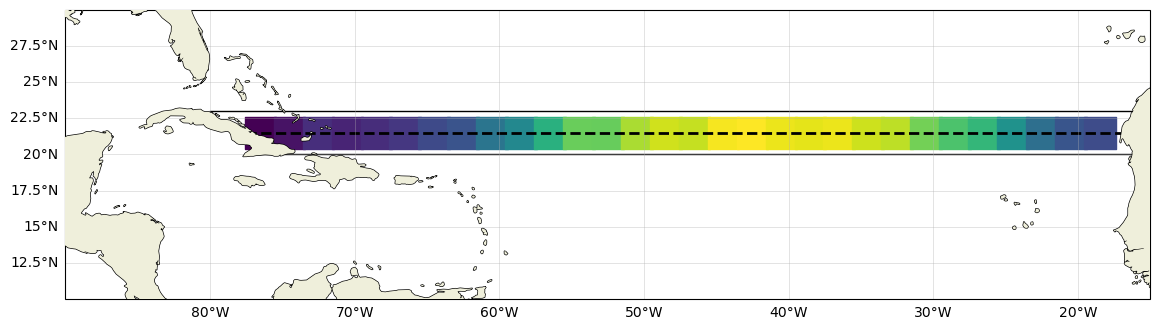

In [22]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(14,12),subplot_kw=dict(projection=cartopy.crs.PlateCarree()))

plt.plot([-80, -16], [23, 23],'k', linewidth=1,transform=cartopy.crs.PlateCarree())
plt.plot([-77.5, -16], [21.5, 21.5],'k--', linewidth=2,transform=cartopy.crs.PlateCarree())
plt.plot([-77.5, -16], [20, 20],'k', linewidth=1,transform=cartopy.crs.PlateCarree())

plt.scatter(ds.longitude,np.repeat(ds.latitude,len(ds.longitude)),c=ds.absolute_salinity.isel(depth=10).mean(dim='time').transpose(),s=520,marker='s',transform=cartopy.crs.PlateCarree())

#ax.add_patch(Rectangle(xy=(ds.longitude[0],ds.latitude,len(ds.longitude))),width=2, height=3,linewidth=1, color=ds.absolute_salinity.isel(depth=10).mean(dim='time').transpose()))

ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
ax.set_ylim(10,30)
ax.set_xlim(-90,-15)


## Decadal means

In [23]:
## Remove all-time means first to calculate anomalies
ds['salinity_anomaly'] = ds.absolute_salinity -clim_mean_ds.absolute_salinity
ds['temperature_anomaly'] = ds.conservative_temperature -clim_mean_ds.conservative_temperature
ds['density_anomaly'] = ds.potential_density -clim_mean_ds.potential_density
ds['psu_anomaly'] = ds.practical_salinity -clim_mean_ds.practical_salinity
ds['pt_anomaly'] = ds.potential_temperature -clim_mean_ds.potential_temperature

## Decadal mean since 1960
decadal_ds = ds.copy()
decadal_ds['time'] = (decadal_ds.time.dt.year//10)*10
decadal_ds = decadal_ds.where(decadal_ds.time>=1960,drop=True)
decadal_ds = decadal_ds.groupby(decadal_ds.time).mean()

## Add all-time means back in and replace original variables
decadal_ds['absolute_salinity'] = decadal_ds.salinity_anomaly +clim_mean_ds.absolute_salinity
decadal_ds['conservative_temperature'] = decadal_ds.temperature_anomaly +clim_mean_ds.conservative_temperature
decadal_ds['potential_density'] = decadal_ds.density_anomaly +clim_mean_ds.potential_density
decadal_ds['practical_salinity'] = decadal_ds.psu_anomaly +clim_mean_ds.practical_salinity
decadal_ds['potential_temperature'] = decadal_ds.pt_anomaly +clim_mean_ds.potential_temperature

## Delete anomaly variables
decadal_ds = decadal_ds.drop(['salinity_anomaly','temperature_anomaly','density_anomaly', 'pt_anomaly', 'psu_anomaly','num_profs'])
decadal_ds

<xarray.Dataset>
Dimensions:                   (time: 7, depth: 74, longitude: 31, latitude: 1)
Coordinates:
  * longitude                 (longitude) float64 -76.5 -74.5 ... -18.5 -16.5
  * latitude                  (latitude) float64 21.5
  * depth                     (depth) int64 0 5 10 15 20 ... 6050 6300 6550 6800
  * time                      (time) int64 1960 1970 1980 1990 2000 2010 2020
Data variables:
    conservative_temperature  (time, depth, longitude, latitude) float64 26.5...
    absolute_salinity         (time, depth, longitude, latitude) float64 36.8...
    potential_density         (time, depth, longitude, latitude) float64 1.02...
    potential_temperature     (time, depth, longitude, latitude) float64 26.5...
    practical_salinity        (time, depth, longitude, latitude) float64 36.6...

## MASK:

Mask based on the all-time mean fields to grab where there is NON-nan data. This way, can look at the decadal means and fill where those are nan with the all-time means.

### Before:

(5000.0, 0.0)

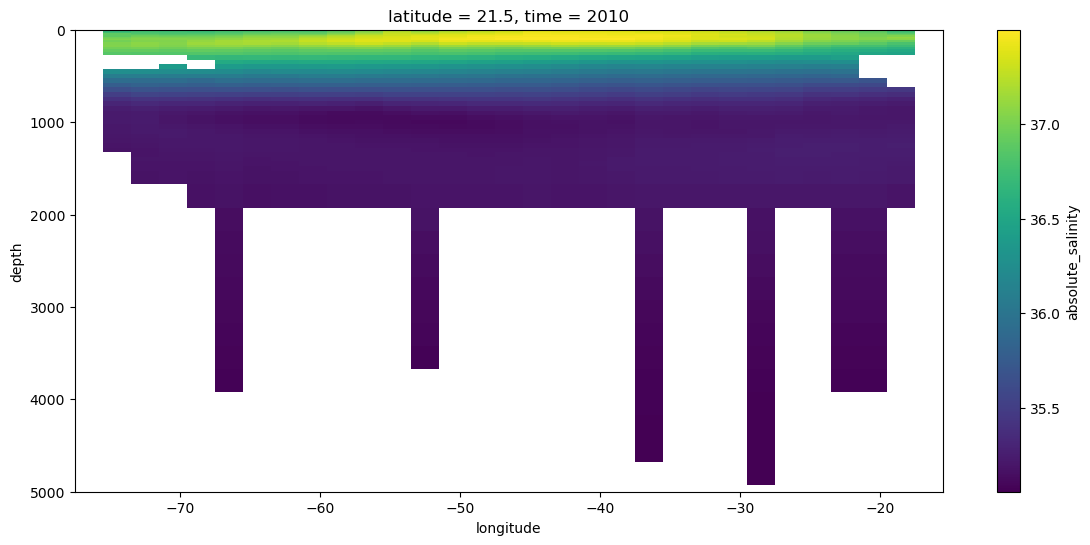

In [24]:
plt.figure(figsize=(14,6))
decadal_ds.absolute_salinity.isel(time=5).plot()
plt.ylim(5000,0)

In [25]:
decadal_ds = decadal_ds.combine_first(clim_mean_ds.isel(latitude=0))
decadal_ds = decadal_ds.isel(latitude=0)
decadal_ds = decadal_ds.drop(['num_profs'])
decadal_ds

<xarray.Dataset>
Dimensions:                   (time: 7, depth: 74, longitude: 31)
Coordinates:
  * longitude                 (longitude) float64 -76.5 -74.5 ... -18.5 -16.5
    latitude                  float64 21.5
  * depth                     (depth) int64 0 5 10 15 20 ... 6050 6300 6550 6800
  * time                      (time) int64 1960 1970 1980 1990 2000 2010 2020
Data variables:
    conservative_temperature  (time, depth, longitude) float64 26.52 ... nan
    absolute_salinity         (time, depth, longitude) float64 36.8 ... nan
    potential_density         (time, depth, longitude) float64 1.024e+03 ... nan
    potential_temperature     (time, depth, longitude) float64 26.58 ... nan
    practical_salinity        (time, depth, longitude) float64 36.63 ... nan

## After

(5000.0, 0.0)

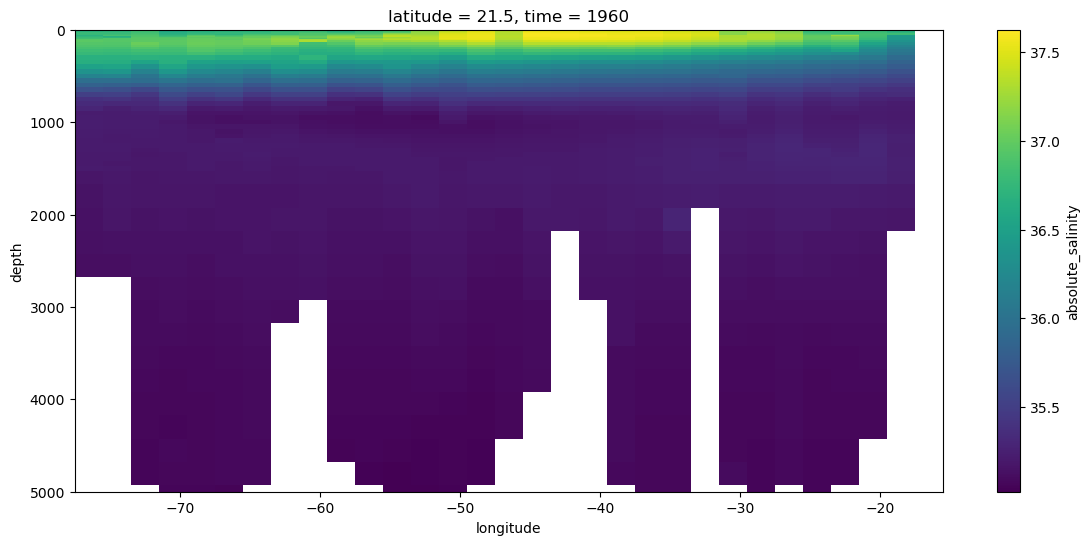

In [26]:
plt.figure(figsize=(14,6))
decadal_ds.absolute_salinity.isel(time=0).plot()
plt.ylim(5000,0)

In [27]:
decadal_ds

<xarray.Dataset>
Dimensions:                   (time: 7, depth: 74, longitude: 31)
Coordinates:
  * longitude                 (longitude) float64 -76.5 -74.5 ... -18.5 -16.5
    latitude                  float64 21.5
  * depth                     (depth) int64 0 5 10 15 20 ... 6050 6300 6550 6800
  * time                      (time) int64 1960 1970 1980 1990 2000 2010 2020
Data variables:
    conservative_temperature  (time, depth, longitude) float64 26.52 ... nan
    absolute_salinity         (time, depth, longitude) float64 36.8 ... nan
    potential_density         (time, depth, longitude) float64 1.024e+03 ... nan
    potential_temperature     (time, depth, longitude) float64 26.58 ... nan
    practical_salinity        (time, depth, longitude) float64 36.63 ... nan

## Put on 1 m dz

In [28]:
dz = 1
grid_depth = np.arange(0.5, decadal_ds.depth.max().values, dz)

def depth_interp(old_depth,vel,new_depth):
    interp_func = interp1d(old_depth, vel, kind='linear')
    return interp_func(new_depth)

# Apply the function using xarray's apply_ufunc
decadal_ds = xr.apply_ufunc(
    depth_interp,                            # function to apply
    decadal_ds.depth,                           # additional argument to pass to the function
    decadal_ds,                        # additional argument to pass to the function
    grid_depth,                              # input array
    input_core_dims=[['depth'], ['depth'],['new_depth']],  # core dimensions for input arrays
    output_core_dims=[['new_depth']],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[decadal_ds.conservative_temperature.dtype]      # output dtype
)
decadal_ds = decadal_ds.rename({'new_depth':'depth'})
decadal_ds['depth'] = grid_depth
decadal_ds

<xarray.Dataset>
Dimensions:                   (time: 7, longitude: 31, depth: 6800)
Coordinates:
    latitude                  float64 21.5
  * longitude                 (longitude) float64 -76.5 -74.5 ... -18.5 -16.5
  * time                      (time) int64 1960 1970 1980 1990 2000 2010 2020
  * depth                     (depth) float64 0.5 1.5 2.5 ... 6.798e+03 6.8e+03
Data variables:
    conservative_temperature  (time, longitude, depth) float64 26.48 ... nan
    absolute_salinity         (time, longitude, depth) float64 36.79 ... nan
    potential_density         (time, longitude, depth) float64 1.024e+03 ... nan
    potential_temperature     (time, longitude, depth) float64 26.54 ... nan
    practical_salinity        (time, longitude, depth) float64 36.62 ... nan

## Trends of properties on depth levels

In [29]:
def property_slope(var):
    return(linregress(decadal_ds.time.values,var)[0])

def property_pval(var):
    return(linregress(decadal_ds.time.values,var)[3])

def property_e(var):
    return(linregress(decadal_ds.time.values,var)[4])

# Apply the function using xarray's apply_ufunc
atl_slopes = xr.apply_ufunc(
    property_slope,                            # function to apply
    decadal_ds,                           # additional argument to pass to the function
    input_core_dims=[['time']],  # core dimensions for input arrays
    output_core_dims=[[]],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[decadal_ds.practical_salinity.dtype]      # output dtype
)

# Apply the function using xarray's apply_ufunc
atl_pval = xr.apply_ufunc(
    property_pval,                            # function to apply
    decadal_ds,                           # additional argument to pass to the function
    input_core_dims=[['time']],  # core dimensions for input arrays
    output_core_dims=[[]],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[decadal_ds.practical_salinity.dtype]      # output dtype
)

# Apply the function using xarray's apply_ufunc
atl_e = xr.apply_ufunc(
    property_e,                            # function to apply
    decadal_ds,                           # additional argument to pass to the function
    input_core_dims=[['time']],  # core dimensions for input arrays
    output_core_dims=[[]],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[decadal_ds.practical_salinity.dtype]      # output dtype
)


atl_slopes = atl_slopes.rename({'conservative_temperature':'conservative_temperature_slope', 'absolute_salinity':'absolute_salinity_slope', 'potential_density':'potential_density_slope',
                                'potential_temperature':'potential_temperature_slope', 'practical_salinity':'practical_salinity_slope'})

atl_pval = atl_pval.rename({'conservative_temperature':'conservative_temperature_pval', 'absolute_salinity':'absolute_salinity_pval', 'potential_density':'potential_density_pval',
                                'potential_temperature':'potential_temperature_pval', 'practical_salinity':'practical_salinity_pval'})

atl_e = atl_e.rename({'conservative_temperature':'conservative_temperature_e', 'absolute_salinity':'absolute_salinity_e', 'potential_density':'potential_density_e',
                                'potential_temperature':'potential_temperature_e', 'practical_salinity':'practical_salinity_e'})

atl_trends = xr.merge([atl_slopes,atl_pval,atl_e])
atl_trends                            

<xarray.Dataset>
Dimensions:                         (longitude: 31, depth: 6800)
Coordinates:
    latitude                        float64 21.5
  * longitude                       (longitude) float64 -76.5 -74.5 ... -16.5
  * depth                           (depth) float64 0.5 1.5 ... 6.8e+03
Data variables: (12/15)
    conservative_temperature_slope  (longitude, depth) float64 0.008433 ... nan
    absolute_salinity_slope         (longitude, depth) float64 -0.003979 ... nan
    potential_density_slope         (longitude, depth) float64 -0.002273 ... nan
    potential_temperature_slope     (longitude, depth) float64 0.008314 ... nan
    practical_salinity_slope        (longitude, depth) float64 -0.00396 ... nan
    conservative_temperature_pval   (longitude, depth) float64 0.6151 ... nan
    ...                              ...
    practical_salinity_pval         (longitude, depth) float64 0.01286 ... nan
    conservative_temperature_e      (longitude, depth) float64 0.01574 ... nan
    absolute_salinity_e             (longitude, depth) float64 0.001052 ... nan
    potential_density_e             (longitude, depth) float64 0.005617 ... nan
    potential_temperature_e         (longitude, depth) float64 0.01576 ... nan
    practical_salinity_e            (longitude, depth) float64 0.001047 ... nan

## Load GLORYS velocity fields

In [30]:
fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/*.nc')
glorys = xr.open_mfdataset(fnames,data_vars='minimal',coords='minimal',compat='override',chunks='auto')
glorys = glorys.drop(['so','thetao'])
glorys

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 265, longitude: 1009, time: 373)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 8.0 8.083 8.167 8.25 ... 29.83 29.92 30.0
  * longitude  (longitude) float32 -98.0 -97.92 -97.83 ... -14.17 -14.08 -14.0
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2023-12-01
Data variables:
    uo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
Attributes: (12/14)
    Conventions:                   CF-1.6
    area:                          GLOBAL
    contact:                       servicedesk.cmems@mercator-ocean.eu
    credit:                        E.U. Copernicus Marine Service Information...
    dataset:                       global-reanalysis-001-030-monthly
    institution:                   Mercator Ocean
    ...                            ...
    product:                       GLOBAL_REANALYSIS_001_030
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    references:                    http://marine.copernicus.eu
    source:                        MERCATOR GLORYS12V1
    title:                         Monthly mean fields for product GLOBAL_REA...

## Create greater Atlantic slice

In [31]:
glorys_atl = glorys.where((glorys.latitude==21.5) & (glorys.longitude>=-77.5),drop=True)
glorys_atl

<xarray.Dataset>
Dimensions:    (time: 373, depth: 50, latitude: 1, longitude: 763)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 21.5
  * longitude  (longitude) float32 -77.5 -77.42 -77.33 ... -14.17 -14.08 -14.0
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2023-12-01
Data variables:
    uo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 1, 453), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 1, 453), meta=np.ndarray>
Attributes: (12/14)
    Conventions:                   CF-1.6
    area:                          GLOBAL
    contact:                       servicedesk.cmems@mercator-ocean.eu
    credit:                        E.U. Copernicus Marine Service Information...
    dataset:                       global-reanalysis-001-030-monthly
    institution:                   Mercator Ocean
    ...                            ...
    product:                       GLOBAL_REANALYSIS_001_030
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    references:                    http://marine.copernicus.eu
    source:                        MERCATOR GLORYS12V1
    title:                         Monthly mean fields for product GLOBAL_REA...

In [32]:
# plt.figure(figsize=(14,6))
# glorys_atl.vo.isel(latitude=0).mean(dim='time').plot()
# plt.ylim(5500,0)
# #plt.xlim(-80,-65)
# #plt.xlim(-30,-10)

## Interpolate onto EN4 longitude grid

In [33]:
# dz = 1
# grid_depth = np.arange(0.5, glorys_atl.depth.max().values, dz)

# def depth_interp(old_depth,vel,new_depth):
#     # new_vel = np.empty((len(new_depth),len(glorys_atl.longitude)))
#     # new_vel[:] = np.nan

#     interp_func = interp1d(old_depth, vel, kind='linear')
#     return interp_func(new_depth)

#     # for x in np.arange(0,len(glorys_atl.longitude)):
#     #     interp_func = interp1d(old_depth, vel[:,x], kind='linear')
#     #     new_vel[:,x] = interp_func(new_depth)
#     # return new_vel

# glorys_atl = glorys_atl.chunk({'depth': -1,'longitude': -1,'time':-1})

# # Apply the function using xarray's apply_ufunc
# new_vel = xr.apply_ufunc(
#     depth_interp,                            # function to apply
#     glorys_atl.depth,                           # additional argument to pass to the function
#     glorys_atl.vo.isel(latitude=0),                        # additional argument to pass to the function
#     grid_depth,                              # input array
#     input_core_dims=[['depth'], ['depth'],['new_depth']],  # core dimensions for input arrays
#     output_core_dims=[['new_depth']],            # core dimensions for output array
#     vectorize=True,                          # vectorize the function
#     dask='parallelized',                     # enable parallel computation with dask
#     output_dtypes=[glorys_atl.vo.dtype]      # output dtype
# )
# new_vel

## Make new xr dataset with this array for saving

In [34]:
# # Create the xarray dataset
# glorys_atl_vo_interp_ds = xr.Dataset(
#     {
#         "vvel": (["time","longitude", "depth"], new_vel.values)
#     },
#     coords={
#         "time": glorys_atl.time.values,
#         "longitude": glorys_atl.longitude.values,
#         "depth": grid_depth.flatten(),
#         "latitude":np.atleast_1d(21.0),
#     },
# )
# glorys_atl_vo_interp_ds

In [35]:
# glorys_atl_vo_interp_ds.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_21_5N_1m_dz_vvel_interp_time_series.nc')

## Reload

In [36]:
glorys_atl_vo_interp_ds = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_21_5N_1m_dz_vvel_interp_time_series.nc')
glorys_atl_vo_interp_ds = glorys_atl_vo_interp_ds.isel(latitude=0)
glorys_atl_vo_interp_ds

<xarray.Dataset>
Dimensions:    (time: 373, longitude: 763, depth: 5728)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2023-12-01
  * longitude  (longitude) float32 -77.5 -77.42 -77.33 ... -14.17 -14.08 -14.0
  * depth      (depth) float64 0.5 1.5 2.5 3.5 ... 5.726e+03 5.726e+03 5.728e+03
    latitude   float64 21.0
Data variables:
    vvel       (time, longitude, depth) float32 ...

## Transport per unit depth

In [37]:
dx = geopy.distance.geodesic([glorys_atl.longitude.values[0],glorys_atl.latitude.values[0]], [glorys_atl.longitude.values[1],glorys_atl.latitude.values[0]]).m
glorys_mean_atl_vvel = glorys_atl_vo_interp_ds.vvel.mean(dim='time')
#atl_transport_per_unit_depth = (glorys_atl_vo_interp_ds.vvel*dx).sum(dim=['longitude']).mean(dim='time')
atl_transport_per_unit_depth = (glorys_mean_atl_vvel*dx)
atl_transport_per_unit_depth.sum()/(10**6)

<xarray.DataArray 'vvel' ()>
array(-29.196842)
Coordinates:
    latitude  float64 21.0

## Put on same grid

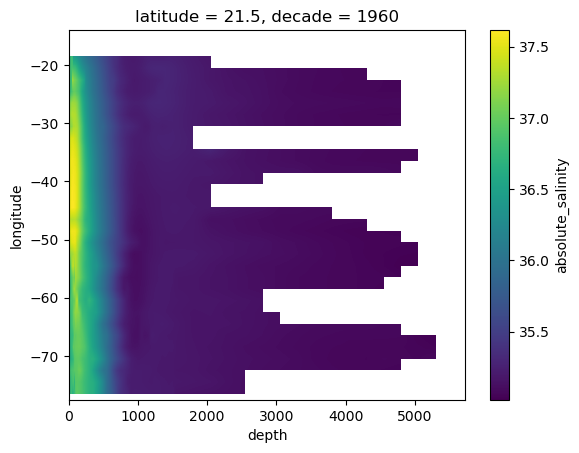

In [38]:
decadal_mean_ds_atl = decadal_ds.interp_like(glorys_atl_vo_interp_ds.mean(dim=['time']))
decadal_mean_ds_atl = decadal_mean_ds_atl.rename({'time':'decade'})
decadal_mean_ds_atl.absolute_salinity.isel(decade=0).plot()

## Yucatan Straits Transport

In [39]:
yucatan_pt1 = [-86.742, 21.1256]
yucatan_pt2 = [-84.9348, 21.837]

yucatan_dx = 9000

pts, dist = calculate_transect(yucatan_pt1, yucatan_pt2, yucatan_dx) # 9km spacing to ~match the 1/12 deg GLORYS resolution

glorys_rn = glorys.rename({'longitude': 'x','latitude': 'y'})


# Interpolate Copernicus Transect
yucatan = glorys_rn.interp(
    x=xr.DataArray(pts[:,0], dims="point"),
    y=xr.DataArray(pts[:,1], dims="point"),
)

/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/pyproj/geod.py:681: UserWarning: Back azimuth is being returned by default to be compatible with fwd()This is a breaking change for pyproj 3.5+.To avoid this warning, set return_back_azimuth=True.Otherwise, to restore old behaviour, set return_back_azimuth=False.This warning will be removed in future version.
  warnings.warn(


/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(-95.0, -70.0)

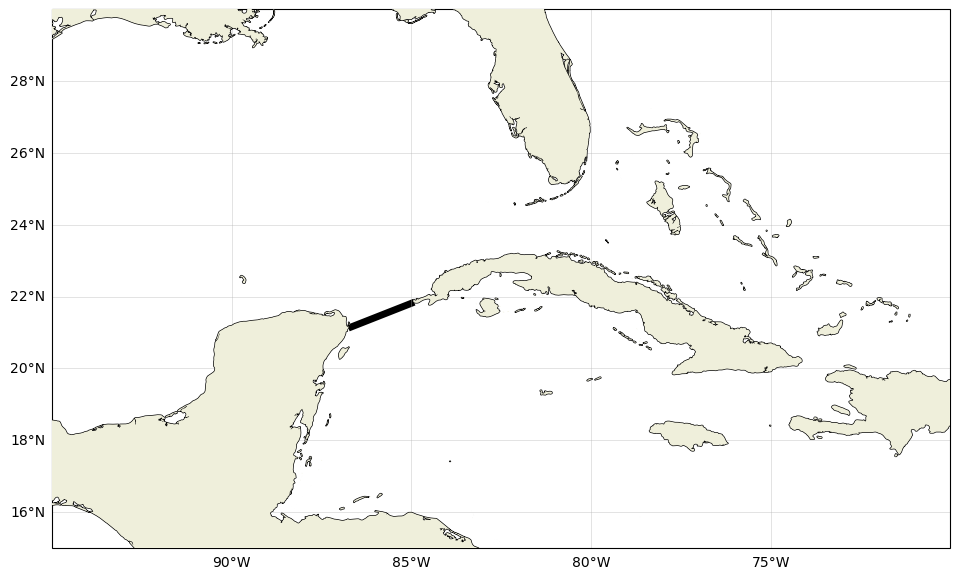

In [40]:
fig, ax = plt.subplots(figsize=(14,7),subplot_kw=dict(projection=cartopy.crs.PlateCarree()))

plt.plot([yucatan.x[-1], yucatan.x[0]], [yucatan.y[-1], yucatan.y[0]],'k', linewidth=5,transform=cartopy.crs.PlateCarree())

ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
ax.set_ylim(15,30)
ax.set_xlim(-95,-70)

## Interp onto regular depth grid to make the transport calculations smoother

In [41]:
# dz = 1
# grid_depth = np.arange(0.5, np.nanmax(yucatan.depth.values), dz)


# yucatan = yucatan.chunk({'time': -1, 'depth':-1})



# # Define a function that applies np.gradient along the depth dimension
# def interp_along_depth(depth, var, grid_depth):
#     interp_func = interp1d(depth, var, kind='linear',fill_value=np.nan,bounds_error=False)
#     return interp_func(grid_depth)


# # Use xarray's apply_ufunc to interpolate along the depth dimension
# yucatan_uvel_interp = xr.apply_ufunc(
#     interp_along_depth,          # function to apply
#     yucatan['depth'],            # depth array
#     yucatan['uo'],        # cross_vel array
#     grid_depth,                  # additional argument: new depth levels
#     input_core_dims=[['depth'], ['time', 'point', 'depth'], ['grid_depth']],  # specify input dimensions
#     output_core_dims=[['time', 'point', 'grid_depth']],           # specify output dimension
#     vectorize=True,              # vectorize the function
#     dask='parallelized',         # enable parallel computation with dask
#     output_dtypes=[yucatan.uo.dtype]     # output dtype
# )

# # Use xarray's apply_ufunc to interpolate along the depth dimension
# yucatan_vvel_interp = xr.apply_ufunc(
#     interp_along_depth,          # function to apply
#     yucatan['depth'],            # depth array
#     yucatan['vo'],        # cross_vel array
#     grid_depth,                  # additional argument: new depth levels
#     input_core_dims=[['depth'], ['time', 'point', 'depth'], ['grid_depth']],  # specify input dimensions
#     output_core_dims=[['time', 'point', 'grid_depth']],           # specify output dimension
#     vectorize=True,              # vectorize the function
#     dask='parallelized',         # enable parallel computation with dask
#     output_dtypes=[yucatan.uo.dtype]     # output dtype
# )


In [42]:
# # Create a new xarray Dataset with the interpolated data
# yucatan_interp = xr.Dataset(
#     {
#         'uvel': (['time', 'point', 'depth'], yucatan_uvel_interp.values),
#         'vvel': (['time', 'point', 'depth'], yucatan_vvel_interp.values),        
#     },
#     coords={
#         'time': yucatan.time.values,
#         'point': yucatan.point.values,
#         'depth': grid_depth  # Use grid_depth as the new depth dimension
#     }
# )
# yucatan_interp

## Save

In [43]:
# yucatan_interp.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_Yucatan_Straits_Interp.nc')

## Reload

In [44]:
yucatan_interp = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_Yucatan_Straits_Interp.nc')
yucatan_interp = yucatan_interp.drop(['uvel'])
yucatan_interp

<xarray.Dataset>
Dimensions:  (time: 373, point: 22, depth: 5728)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2023-12-01
  * point    (point) int64 0 1 2 3 4 5 6 7 8 9 ... 12 13 14 15 16 17 18 19 20 21
  * depth    (depth) float64 0.5 1.5 2.5 3.5 ... 5.726e+03 5.726e+03 5.728e+03
Data variables:
    vvel     (time, point, depth) float32 ...

## Clip Yucatan transport to the sill depth of the FS. Otherwise, the ATL interior flow would not technically be in a mass balance with the flow below that depth

In [45]:
fs_sill_depth = 760
yucatan_interp = yucatan_interp.where(yucatan_interp.depth<=fs_sill_depth,drop=True)
yucatan_interp

<xarray.Dataset>
Dimensions:  (time: 373, point: 22, depth: 760)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2023-12-01
  * point    (point) int64 0 1 2 3 4 5 6 7 8 9 ... 12 13 14 15 16 17 18 19 20 21
  * depth    (depth) float64 0.5 1.5 2.5 3.5 4.5 ... 756.5 757.5 758.5 759.5
Data variables:
    vvel     (time, point, depth) float32 0.58 0.5789 0.5765 ... nan nan nan

In [46]:
yucatan_transport_per_unit_depth = (yucatan_interp.vvel*yucatan_dx).sum(dim=['point']).mean(dim='time')
yucatan_transport_per_unit_depth.sum()/(10**6)

<xarray.DataArray 'vvel' ()>
array(26.651304)

## Adjust to achieve mass balance

In [47]:
## Difference in the transport values between the yucatan straits and greater atlantic
trsp_diff = -(atl_transport_per_unit_depth.sum()+yucatan_transport_per_unit_depth.sum()).values
## Find the area of the greater Atlantic that is not nan
atl_finite_depths = np.sum((np.isfinite(glorys_mean_atl_vvel).values==True),axis=1)
atl_area = np.sum(atl_finite_depths)*dx
## divide that transport diff by the depth of the profile to find the adjustment per unit depth
adjustment_per_unit_depth = trsp_diff/atl_area ## m
print('adjustment to N-S velocity of +'+str((np.round((adjustment_per_unit_depth*100),6)))+' cm/s')

adjustment to N-S velocity of +0.008937 cm/s


In [48]:
for x in np.arange(0,len(atl_finite_depths)):
    glorys_mean_atl_vvel[x,0:atl_finite_depths[x]] = glorys_mean_atl_vvel[x,0:atl_finite_depths[x]]+adjustment_per_unit_depth

atl_transport_per_unit_depth = (glorys_mean_atl_vvel*dx)


## Confirm balanced

In [49]:
yucatan_transport_per_unit_depth.sum()/(10**6)

<xarray.DataArray 'vvel' ()>
array(26.651304)

In [50]:
atl_transport_per_unit_depth.sum()/(10**6)

<xarray.DataArray 'vvel' ()>
array(-26.651302)
Coordinates:
    latitude  float64 21.0

## Load CTF trends

In [51]:
decadal_mean_ds_ctf = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/EN4_CTF_1960_2020_Mean_Decadal_Profiles_Trends.nc')

## Make same depth as the transport ds
dz = 1
grid_depth = np.arange(0.5, 760.5, dz)

def depth_interp(old_depth,vel,new_depth):
    interp_func = interp1d(old_depth, vel, kind='linear')
    return interp_func(new_depth)


# Apply the function using xarray's apply_ufunc
decadal_mean_ds_ctf = xr.apply_ufunc(
    depth_interp,                            # function to apply
    decadal_mean_ds_ctf.depth,                           # additional argument to pass to the function
    decadal_mean_ds_ctf,                        # additional argument to pass to the function
    grid_depth,                              # input array
    input_core_dims=[['depth'], ['depth'],['new_depth']],  # core dimensions for input arrays
    output_core_dims=[['new_depth']],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[decadal_mean_ds_ctf.temp.dtype]      # output dtype
)

decadal_mean_ds_ctf = decadal_mean_ds_ctf.rename({'new_depth':'depth'})
decadal_mean_ds_ctf['depth'] = grid_depth
#decadal_mean_ds_ctf = decadal_mean_ds_ctf.transpose()
decadal_mean_ds_ctf

<xarray.Dataset>
Dimensions:     (decade: 7, depth: 760)
Coordinates:
  * decade      (decade) int64 1960 1970 1980 1990 2000 2010 2020
  * depth       (depth) float64 0.5 1.5 2.5 3.5 4.5 ... 756.5 757.5 758.5 759.5
Data variables: (12/16)
    temp        (decade, depth) float64 27.42 27.41 27.41 ... 6.775 6.766 6.758
    salt        (decade, depth) float64 35.84 35.86 35.87 ... 35.01 35.01 35.01
    psu         (decade, depth) float64 35.68 35.69 35.7 ... 34.84 34.84 34.84
    pt          (decade, depth) float64 27.44 27.44 27.43 ... 6.781 6.772 6.763
    temp_slope  (depth) float64 0.02264 0.02187 0.02111 ... 0.000194 0.0002187
    salt_slope  (depth) float64 -0.01231 -0.01042 ... -0.0006841 -0.0006789
    ...          ...
    psu_p_val   (depth) float64 0.0781 0.1577 0.2372 ... 0.361 0.3609 0.3608
    pt_p_val    (depth) float64 0.06639 0.05401 0.04163 ... 0.9479 0.9416 0.9353
    temp_e      (depth) float64 0.009525 0.008463 0.0074 ... 0.00399 0.00396
    salt_e      (depth) float64 0.004722 0.004677 ... 0.0006809 0.0006757
    psu_e       (depth) float64 0.0047 0.004656 0.004611 ... 0.0006786 0.0006734
    pt_e        (depth) float64 0.00938 0.008361 0.007342 ... 0.004002 0.003972

# Bootstrap 1,000 simulations with variability in the trends

In [52]:
yucatan_trsp_mean = (yucatan_interp.vvel*yucatan_dx).sum(dim=['point','depth']).mean()
yucatan_trsp_std  = (yucatan_interp.vvel*yucatan_dx).sum(dim=['point','depth']).std()

atl_trsp_mean = (glorys_mean_atl_vvel*dx).sum(dim=['longitude','depth']).mean()
atl_trsp_std  = (glorys_mean_atl_vvel*dx).sum(dim=['longitude','depth']).std()

print('Yucatan Transport Mean: '+str(np.round(yucatan_trsp_mean.values/(10**6),2))+' ± '+str(np.round(yucatan_trsp_std.values/(10**6),2))+' Sv')
print('ATL Interior Transport Mean: '+str(np.round(atl_trsp_mean.values/(10**6),2))+' ± '+str(np.round(atl_trsp_std.values/(10**6),2))+' Sv')


Yucatan Transport Mean: 26.65 ± 4.26 Sv
ATL Interior Transport Mean: -26.65 ± 0.0 Sv


In [53]:
yucatan_finite_depths = np.sum((np.isfinite(yucatan_interp.mean(dim='time').vvel).values==True),axis=0)
yucatan_area = np.sum(yucatan_finite_depths*yucatan_dx)

In [54]:
decadal_mean_ds_ctf

<xarray.Dataset>
Dimensions:     (decade: 7, depth: 760)
Coordinates:
  * decade      (decade) int64 1960 1970 1980 1990 2000 2010 2020
  * depth       (depth) float64 0.5 1.5 2.5 3.5 4.5 ... 756.5 757.5 758.5 759.5
Data variables: (12/16)
    temp        (decade, depth) float64 27.42 27.41 27.41 ... 6.775 6.766 6.758
    salt        (decade, depth) float64 35.84 35.86 35.87 ... 35.01 35.01 35.01
    psu         (decade, depth) float64 35.68 35.69 35.7 ... 34.84 34.84 34.84
    pt          (decade, depth) float64 27.44 27.44 27.43 ... 6.781 6.772 6.763
    temp_slope  (depth) float64 0.02264 0.02187 0.02111 ... 0.000194 0.0002187
    salt_slope  (depth) float64 -0.01231 -0.01042 ... -0.0006841 -0.0006789
    ...          ...
    psu_p_val   (depth) float64 0.0781 0.1577 0.2372 ... 0.361 0.3609 0.3608
    pt_p_val    (depth) float64 0.06639 0.05401 0.04163 ... 0.9479 0.9416 0.9353
    temp_e      (depth) float64 0.009525 0.008463 0.0074 ... 0.00399 0.00396
    salt_e      (depth) float64 0.004722 0.004677 ... 0.0006809 0.0006757
    psu_e       (depth) float64 0.0047 0.004656 0.004611 ... 0.0006786 0.0006734
    pt_e        (depth) float64 0.00938 0.008361 0.007342 ... 0.004002 0.003972

## Add CI to trend datasets

In [55]:
decadal_ds = decadal_ds.assign(pt_ci_low=(["time", "longitude", "depth"], calculate_confidence_interval(decadal_ds.potential_temperature.values, scipy.stats.sem(decadal_ds.potential_temperature,axis=0))[0]),df=6)
decadal_ds = decadal_ds.assign(pt_ci_high=(["time", "longitude", "depth"], calculate_confidence_interval(decadal_ds.potential_temperature.values, scipy.stats.sem(decadal_ds.potential_temperature,axis=0))[1]),df=6)
decadal_ds = decadal_ds.assign(psu_ci_low=(["time", "longitude", "depth"], calculate_confidence_interval(decadal_ds.practical_salinity.values, scipy.stats.sem(decadal_ds.practical_salinity,axis=0))[0]),df=6)
decadal_ds = decadal_ds.assign(psu_ci_high=(["time", "longitude", "depth"], calculate_confidence_interval(decadal_ds.practical_salinity.values, scipy.stats.sem(decadal_ds.practical_salinity,axis=0))[1]),df=6)

atl_trends = atl_trends.assign(pt_ci_low=(["longitude", "depth"], calculate_confidence_interval(atl_trends.potential_temperature_slope.values, atl_trends.potential_temperature_e.values)[0]),df=6)
atl_trends = atl_trends.assign(pt_ci_high=(["longitude", "depth"], calculate_confidence_interval(atl_trends.potential_temperature_slope.values, atl_trends.potential_temperature_e.values)[1]),df=6)
atl_trends = atl_trends.assign(psu_ci_low=(["longitude", "depth"], calculate_confidence_interval(atl_trends.practical_salinity_slope.values, atl_trends.practical_salinity_e.values)[0]),df=6)
atl_trends = atl_trends.assign(psu_ci_high=(["longitude", "depth"], calculate_confidence_interval(atl_trends.practical_salinity_slope.values, atl_trends.practical_salinity_e.values)[1]),df=6)
atl_trends = atl_trends.assign(absolute_salinity_ci_low=(["longitude", "depth"], calculate_confidence_interval(atl_trends.absolute_salinity_slope.values, atl_trends.absolute_salinity_e.values)[0]),df=6)
atl_trends = atl_trends.assign(absolute_salinity_ci_high=(["longitude", "depth"], calculate_confidence_interval(atl_trends.absolute_salinity_slope.values, atl_trends.absolute_salinity_e.values)[1]),df=6)

decadal_mean_ds_ctf = decadal_mean_ds_ctf.assign(pt_ci_low=(["depth"], calculate_confidence_interval(decadal_mean_ds_ctf.pt_slope.values, decadal_mean_ds_ctf.pt_e.values)[0]),df=6)
decadal_mean_ds_ctf = decadal_mean_ds_ctf.assign(pt_ci_high=(["depth"], calculate_confidence_interval(decadal_mean_ds_ctf.pt_slope.values, decadal_mean_ds_ctf.pt_e.values)[1]),df=6)
decadal_mean_ds_ctf = decadal_mean_ds_ctf.assign(psu_ci_low=(["depth"], calculate_confidence_interval(decadal_mean_ds_ctf.psu_slope.values, decadal_mean_ds_ctf.psu_e.values)[0]),df=6)
decadal_mean_ds_ctf = decadal_mean_ds_ctf.assign(psu_ci_high=(["depth"], calculate_confidence_interval(decadal_mean_ds_ctf.psu_slope.values, decadal_mean_ds_ctf.psu_e.values)[1]),df=6)

decadal_mean_ds_ctf = decadal_mean_ds_ctf.assign(absolute_salinity_ci_low=(["depth"], calculate_confidence_interval(decadal_mean_ds_ctf.salt_slope.values, decadal_mean_ds_ctf.salt_e.values)[0]),df=6)
decadal_mean_ds_ctf = decadal_mean_ds_ctf.assign(absolute_salinity_ci_high=(["depth"], calculate_confidence_interval(decadal_mean_ds_ctf.salt_slope.values, decadal_mean_ds_ctf.salt_e.values)[1]),df=6)


decadal_mean_ds_ctf = decadal_mean_ds_ctf.assign(pt_mean_ci_low=(["time", "depth"], calculate_confidence_interval(decadal_mean_ds_ctf.pt.values, scipy.stats.sem(decadal_mean_ds_ctf.pt.values,axis=0))[0]),df=6)
decadal_mean_ds_ctf = decadal_mean_ds_ctf.assign(pt_mean_ci_high=(["time", "depth"], calculate_confidence_interval(decadal_mean_ds_ctf.pt.values, scipy.stats.sem(decadal_mean_ds_ctf.pt.values,axis=0))[1]),df=6)
decadal_mean_ds_ctf = decadal_mean_ds_ctf.assign(psu_mean_ci_low=(["time", "depth"], calculate_confidence_interval(decadal_mean_ds_ctf.psu.values, scipy.stats.sem(decadal_mean_ds_ctf.psu.values,axis=0))[0]),df=6)
decadal_mean_ds_ctf = decadal_mean_ds_ctf.assign(psu_mean_ci_high=(["time", "depth"], calculate_confidence_interval(decadal_mean_ds_ctf.psu.values, scipy.stats.sem(decadal_mean_ds_ctf.psu.values,axis=0))[1]),df=6)


In [56]:
atl_trends_interp = atl_trends.interp_like(atl_transport_per_unit_depth)
decadal_ds_interp = decadal_ds.interp_like(atl_transport_per_unit_depth)
decadal_ds_interp

<xarray.Dataset>
Dimensions:                   (time: 7, longitude: 763, depth: 5728)
Coordinates:
    latitude                  float64 21.5
  * time                      (time) int64 1960 1970 1980 1990 2000 2010 2020
  * longitude                 (longitude) float32 -77.5 -77.42 ... -14.08 -14.0
  * depth                     (depth) float64 0.5 1.5 ... 5.726e+03 5.728e+03
Data variables:
    conservative_temperature  (time, longitude, depth) float64 nan nan ... nan
    absolute_salinity         (time, longitude, depth) float64 nan nan ... nan
    potential_density         (time, longitude, depth) float64 nan nan ... nan
    potential_temperature     (time, longitude, depth) float64 nan nan ... nan
    practical_salinity        (time, longitude, depth) float64 nan nan ... nan
    pt_ci_low                 (time, longitude, depth) float64 nan nan ... nan
    df                        int64 6
    pt_ci_high                (time, longitude, depth) float64 nan nan ... nan
    psu_ci_low                (time, longitude, depth) float64 nan nan ... nan
    psu_ci_high               (time, longitude, depth) float64 nan nan ... nan

## Example of CI

Text(0.5, 1.0, 'Shaded by 95% confidence interval\n\nNOTE the ATL profile is an mean of what are individual profiles\nacross the ATL interior section used in the actual calculation')

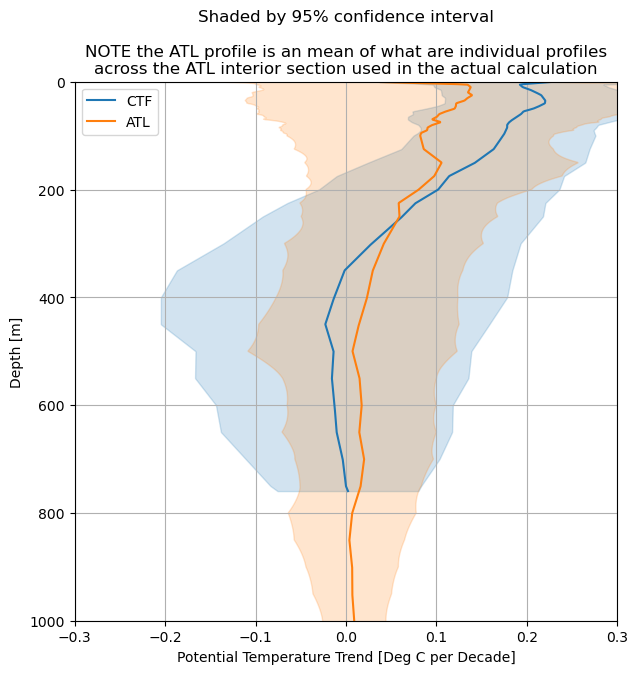

In [57]:
plt.figure(figsize=(7,7))
plt.plot(10*decadal_mean_ds_ctf.temp_slope,decadal_mean_ds_ctf.depth,label='CTF',color='tab:blue')
plt.fill_betweenx(decadal_mean_ds_ctf.depth,10*decadal_mean_ds_ctf.pt_ci_low,10*decadal_mean_ds_ctf.pt_ci_high,color='tab:blue',alpha=0.2)
plt.plot(10*atl_trends_interp.potential_temperature_slope.mean(dim=['longitude']),atl_trends_interp.depth,label='ATL',color='tab:orange')
plt.fill_betweenx(atl_trends_interp.depth,(10*atl_trends_interp.pt_ci_low.mean(dim='longitude')),(10*atl_trends_interp.pt_ci_high.mean(dim='longitude')),color='tab:orange',alpha=0.2)

plt.ylim(1000,0)
plt.xlim(-0.3,0.3)
plt.grid()
plt.legend()
plt.xlabel('Potential Temperature Trend [Deg C per Decade]')
plt.ylabel('Depth [m]')
plt.title('Shaded by 95% confidence interval\n\nNOTE the ATL profile is an mean of what are individual profiles\nacross the ATL interior section used in the actual calculation')

In [58]:
atl_trends_interp

<xarray.Dataset>
Dimensions:                         (longitude: 763, depth: 5728)
Coordinates:
    latitude                        float64 21.5
  * longitude                       (longitude) float32 -77.5 -77.42 ... -14.0
  * depth                           (depth) float64 0.5 1.5 ... 5.728e+03
Data variables: (12/22)
    conservative_temperature_slope  (longitude, depth) float64 nan nan ... nan
    absolute_salinity_slope         (longitude, depth) float64 nan nan ... nan
    potential_density_slope         (longitude, depth) float64 nan nan ... nan
    potential_temperature_slope     (longitude, depth) float64 nan nan ... nan
    practical_salinity_slope        (longitude, depth) float64 nan nan ... nan
    conservative_temperature_pval   (longitude, depth) float64 nan nan ... nan
    ...                              ...
    df                              int64 6
    pt_ci_high                      (longitude, depth) float64 nan nan ... nan
    psu_ci_low                      (longitude, depth) float64 nan nan ... nan
    psu_ci_high                     (longitude, depth) float64 nan nan ... nan
    absolute_salinity_ci_low        (longitude, depth) float64 nan nan ... nan
    absolute_salinity_ci_high       (longitude, depth) float64 nan nan ... nan

## Preallocate DF to stuff results into

In [59]:
nandf = np.empty((10000,14))
nandf[:] = np.nan

df = pd.DataFrame(data = nandf,
                  columns=['yucatan_transport', 'atl_transport', 'net_heat_transport', 'atl_heat_transport', 'ctf_heat_transport',
                           'net_salt_transport', 'atl_salt_transport', 'ctf_salt_transport',
                          'net_fw_transport', 'atl_fw_transport', 'ctf_fw_transport',
                          'net_as_salt_transport', 'atl_as_salt_transport', 'ctf_as_salt_transport'])
df

,yucatan_transport,atl_transport,net_heat_transport,atl_heat_transport,ctf_heat_transport,net_salt_transport,atl_salt_transport,ctf_salt_transport,net_fw_transport,atl_fw_transport,ctf_fw_transport,net_as_salt_transport,atl_as_salt_transport,ctf_as_salt_transport
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Important step to make mean velocity fields for loop below

In [60]:
mean_yucatan_vvel = yucatan_interp.vvel.mean(dim='time')
mean_atl_vvel = glorys_mean_atl_vvel

## Loop it up!

In [117]:
for x in np.arange(0,10000):
    ## Known section mean salinity used for fw transport calculation
    sbar = 35.205
    
    ## Pick a random transport value between +/- the transport standard deviation
    simulation_transport_adjustment = random_val_between_neg_and_pos_input(yucatan_trsp_std.values)
    
    ## Calculate the velocity adjustment based on this transport
    yucatan_vel_adjustment = simulation_transport_adjustment/yucatan_area
    atl_vel_adjustment = -simulation_transport_adjustment/atl_area
    
    ## Adjust
    adjusted_yucatan_vvel = mean_yucatan_vvel.where(np.isfinite(mean_yucatan_vvel)) + yucatan_vel_adjustment
    adjusted_atl_vvel = mean_atl_vvel.where(np.isfinite(mean_atl_vvel)) + atl_vel_adjustment
    ## Transport per unit depth
    adjusted_yucatan_transport_per_unit_depth = adjusted_yucatan_vvel*yucatan_dx
    adjusted_atl_transport_per_unit_depth = adjusted_atl_vvel*dx

    ## Pick a random value between the 95% confidence intervals of the potential temperature and practical salinity slopes for the CTF and ATL interior
    random_atl_pt_slope = random.uniform(atl_trends_interp.pt_ci_low,atl_trends_interp.pt_ci_high)
    random_ctf_pt_slope = random.uniform(decadal_mean_ds_ctf.pt_ci_low,decadal_mean_ds_ctf.pt_ci_high)
    random_atl_psu_slope = random.uniform(atl_trends_interp.psu_ci_low,atl_trends_interp.psu_ci_high)
    random_ctf_psu_slope = random.uniform(decadal_mean_ds_ctf.psu_ci_low,decadal_mean_ds_ctf.psu_ci_high)
    random_atl_as_salt_slope = random.uniform(atl_trends_interp.absolute_salinity_ci_low,atl_trends_interp.absolute_salinity_ci_high)
    random_ctf_as_salt_slope = random.uniform(decadal_mean_ds_ctf.absolute_salinity_ci_low,decadal_mean_ds_ctf.absolute_salinity_ci_high)
  
    ## Calculate the respective heat transports and then the net transport
    atl_heat_transport = (adjusted_atl_transport_per_unit_depth*random_atl_pt_slope*rho_Cp).sum()
    ctf_heat_transport = (adjusted_yucatan_transport_per_unit_depth.sum(dim='point')*random_ctf_pt_slope*rho_Cp).sum()
    net_heat_transport = ctf_heat_transport+atl_heat_transport

    ## Calculate the respective salt transports and then the net transport
    atl_salt_transport = (adjusted_atl_transport_per_unit_depth*random_atl_psu_slope).sum()
    ctf_salt_transport = (adjusted_yucatan_transport_per_unit_depth.sum(dim='point')*random_ctf_psu_slope).sum()
    net_salt_transport = ctf_salt_transport+atl_salt_transport
    
    ## Calculate the respective salt transports and then the net transport
    atl_as_transport = (adjusted_atl_transport_per_unit_depth*random_atl_as_salt_slope).sum()
    ctf_as_transport = (adjusted_yucatan_transport_per_unit_depth.sum(dim='point')*random_ctf_as_salt_slope).sum()
    net_as_transport = ctf_as_transport+atl_as_transport
    
    ## Calculate the respective fw transports and then the net transport
    atl_fw_transport = ((-1/sbar)*(((adjusted_atl_transport_per_unit_depth*random_atl_psu_slope).sum(dim=['longitude','depth']).mean()) - (sbar*adjusted_atl_transport_per_unit_depth).sum()))
    ctf_fw_transport = ((-1/sbar)*(((adjusted_yucatan_transport_per_unit_depth.sum(dim='point')*random_ctf_psu_slope).sum(dim='depth')).mean()-(sbar*adjusted_yucatan_transport_per_unit_depth.sum(dim='point')).sum()))
    net_fw_transport = ctf_fw_transport+atl_fw_transport
    
    
    ## Fill the dataframe now
    df['yucatan_transport'].iloc[x] = adjusted_yucatan_transport_per_unit_depth.sum().values
    df['atl_transport'].iloc[x] = adjusted_atl_transport_per_unit_depth.sum().values
    df['net_heat_transport'].iloc[x] = net_heat_transport
    df['atl_heat_transport'].iloc[x] = atl_heat_transport
    df['ctf_heat_transport'].iloc[x] = ctf_heat_transport
    df['net_salt_transport'].iloc[x] = net_salt_transport
    df['atl_salt_transport'].iloc[x] = atl_salt_transport
    df['ctf_salt_transport'].iloc[x] = ctf_salt_transport
    df['net_fw_transport'].iloc[x]   = net_fw_transport
    df['atl_fw_transport'].iloc[x]   = atl_fw_transport
    df['ctf_fw_transport'].iloc[x]   = ctf_fw_transport
    df['net_as_salt_transport'].iloc[x]   = net_as_transport
    df['atl_as_salt_transport'].iloc[x]   = atl_as_transport
    df['ctf_as_salt_transport'].iloc[x]   = ctf_as_transport        

        

In [62]:
df.ctf_as_salt_transport.mean()/(10**5)

0.23194532128260612

In [63]:
df.ctf_salt_transport.mean()/(10**5)

0.22209104775398908

In [119]:
df.net_fw_transport.std()/(10**5)

0.011994648277541023

In [116]:
(-(adjusted_yucatan_transport_per_unit_depth.sum(dim='point')*random_ctf_psu_slope/sbar)).sum() - (-(sbar*adjusted_yucatan_transport_per_unit_depth.sum(dim='point'))).sum()


<xarray.DataArray ()>
array(8.79819151e+08)

In [69]:
print('Net Heat Transport Trend: '+str(np.round(df.net_heat_transport.mean()/(10**14),4))+' ± '+str(np.round(df.net_heat_transport.std()/(10**14),4))+' PW per decade')

Net Heat Transport Trend: 0.0069 ± 0.0087 PW per decade


In [70]:
print('Net Salt Transport Trend: '+str(np.round(df.net_salt_transport.mean()/(10**5),4))+' ± '+str(np.round(df.net_salt_transport.std()/(10**5),4))+' Sv per decade')

Net Salt Transport Trend: 0.1413 ± 0.426 Sv per decade


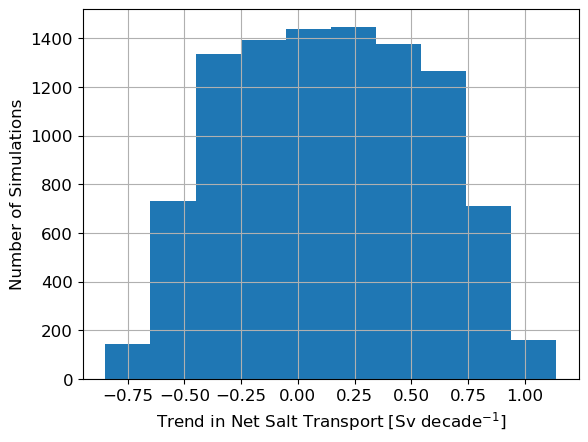

In [71]:
font_size = 12

(df.net_salt_transport/(10**5)).hist()
plt.xlabel('Trend in Net Salt Transport [Sv decade$^{-1}$]',fontsize=font_size)
plt.ylabel('Number of Simulations',fontsize=font_size)
plt.gca().tick_params(axis='both', which='major', labelsize=font_size)

plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/EN4/Full_Bootstrap_Net_Salt_Transport_Trend.png',dpi=300,facecolor='white',bbox_inches='tight')


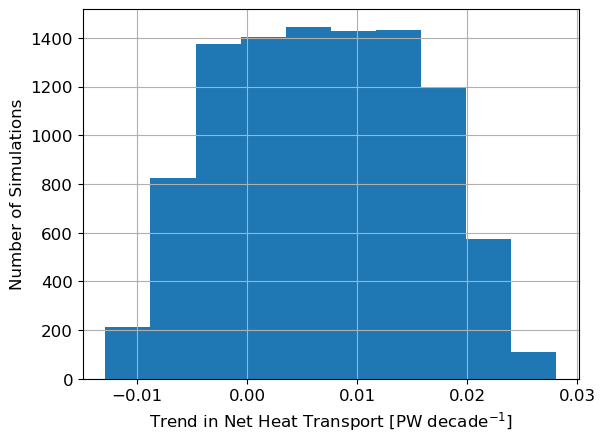

In [72]:
font_size = 12

(df.net_heat_transport/(10**14)).hist()
plt.xlabel('Trend in Net Heat Transport [PW decade$^{-1}$]',fontsize=font_size)
plt.ylabel('Number of Simulations',fontsize=font_size)
plt.gca().tick_params(axis='both', which='major', labelsize=font_size)

plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/EN4/Full_Bootstrap_Net_Heat_Transport_Trend.png',dpi=300,facecolor='white',bbox_inches='tight')


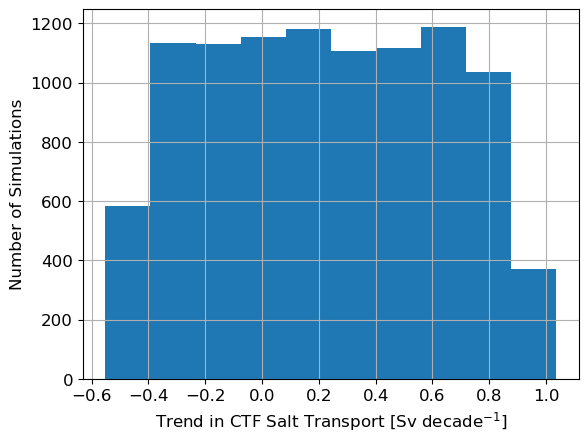

In [73]:
font_size = 12

(df.ctf_salt_transport/(10**5)).hist()
plt.xlabel('Trend in CTF Salt Transport [Sv decade$^{-1}$]',fontsize=font_size)
plt.ylabel('Number of Simulations',fontsize=font_size)
plt.gca().tick_params(axis='both', which='major', labelsize=font_size)

plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/EN4/Full_Bootstrap_CTF_Salt_Transport_Trend.png',dpi=300,facecolor='white',bbox_inches='tight')


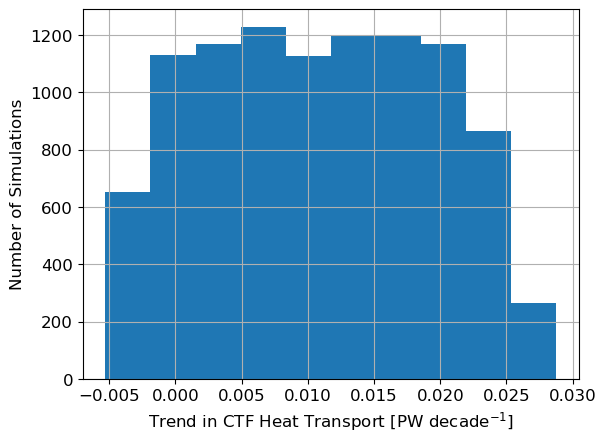

In [74]:
font_size = 12

(df.ctf_heat_transport/(10**14)).hist()
plt.xlabel('Trend in CTF Heat Transport [PW decade$^{-1}$]',fontsize=font_size)
plt.ylabel('Number of Simulations',fontsize=font_size)
plt.gca().tick_params(axis='both', which='major', labelsize=font_size)

plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/EN4/Full_Bootstrap_CTF_Heat_Transport_Trend.png',dpi=300,facecolor='white',bbox_inches='tight')


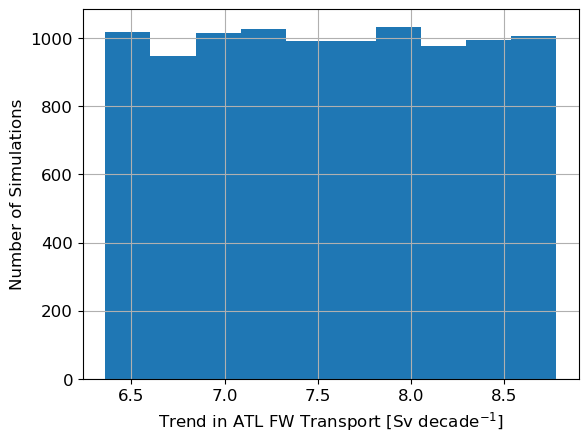

In [123]:
font_size = 12

((df.ctf_fw_transport/(sbar))/(10**5)).hist()
plt.xlabel('Trend in ATL FW Transport [Sv decade$^{-1}$]',fontsize=font_size)
plt.ylabel('Number of Simulations',fontsize=font_size)
plt.gca().tick_params(axis='both', which='major', labelsize=font_size)



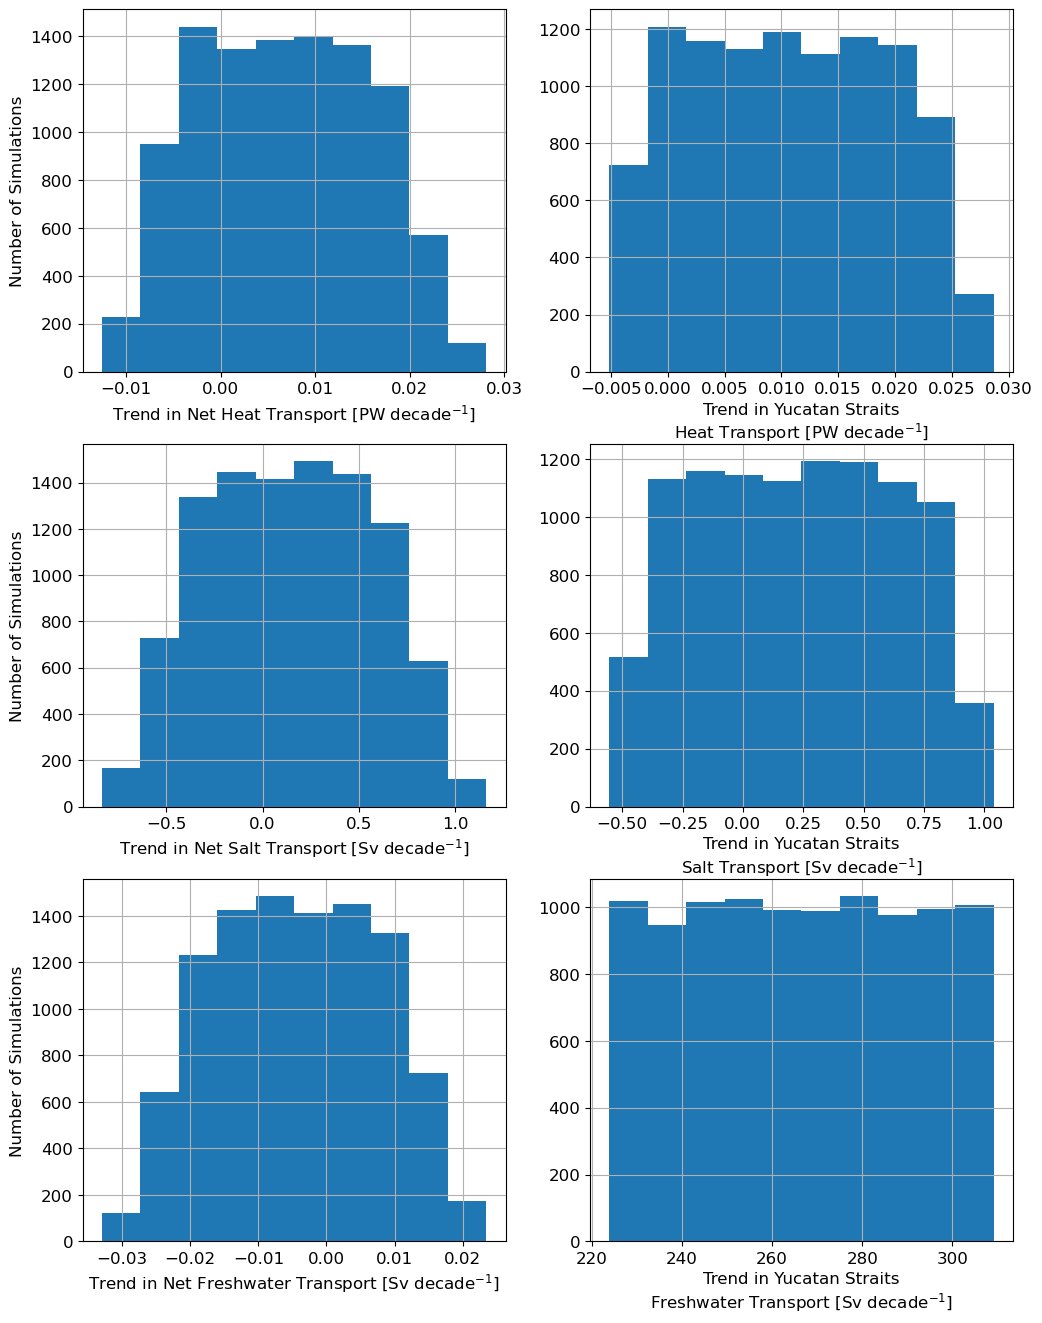

In [124]:


fig, ax = plt.subplots(3,2,figsize=(12,16))

(df.net_heat_transport/(10**14)).hist(ax=ax[0,0])
ax[0,0].set_xlabel('Trend in Net Heat Transport [PW decade$^{-1}$]',fontsize=font_size)
ax[0,0].set_ylabel('Number of Simulations',fontsize=font_size)

(df.net_salt_transport/(10**5)).hist(ax=ax[1,0])
ax[1,0].set_xlabel('Trend in Net Salt Transport [Sv decade$^{-1}$]',fontsize=font_size)
ax[1,0].set_ylabel('Number of Simulations',fontsize=font_size)

(df.net_fw_transport/(10**5)).hist(ax=ax[2,0])
ax[2,0].set_xlabel('Trend in Net Freshwater Transport [Sv decade$^{-1}$]',fontsize=font_size)
ax[2,0].set_ylabel('Number of Simulations',fontsize=font_size)








(df.ctf_heat_transport/(10**14)).hist(ax=ax[0,1])
ax[0,1].set_xlabel('Trend in Yucatan Straits\nHeat Transport [PW decade$^{-1}$]',fontsize=font_size)

(df.ctf_salt_transport/(10**5)).hist(ax=ax[1,1])
ax[1,1].set_xlabel('Trend in Yucatan Straits\nSalt Transport [Sv decade$^{-1}$]',fontsize=font_size)

(df.ctf_fw_transport/(10**5)).hist(ax=ax[2,1])
ax[2,1].set_xlabel('Trend in Yucatan Straits\nFreshwater Transport [Sv decade$^{-1}$]',fontsize=font_size)




ax[0,0].tick_params(axis='both', which='major', labelsize=font_size)
ax[0,1].tick_params(axis='both', which='major', labelsize=font_size)
ax[1,0].tick_params(axis='both', which='major', labelsize=font_size)
ax[1,1].tick_params(axis='both', which='major', labelsize=font_size)
ax[2,0].tick_params(axis='both', which='major', labelsize=font_size)
ax[2,1].tick_params(axis='both', which='major', labelsize=font_size)


plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/EN4/Full_Bootstrap_Net_and_CTF_Transport_Trends.png',dpi=300,facecolor='white',bbox_inches='tight')


## Now do for the actual transports!

In [76]:
nandf = np.empty((10000,11))
nandf[:] = np.nan

transport_df = pd.DataFrame(data = nandf,
                  columns=['yucatan_transport', 'atl_transport', 'net_heat_transport', 'atl_heat_transport', 'ctf_heat_transport',
                           'net_salt_transport', 'atl_salt_transport', 'ctf_salt_transport',
                            'net_fw_transport', 'atl_fw_transport', 'ctf_fw_transport'])

transport_df

,yucatan_transport,atl_transport,net_heat_transport,atl_heat_transport,ctf_heat_transport,net_salt_transport,atl_salt_transport,ctf_salt_transport,net_fw_transport,atl_fw_transport,ctf_fw_transport
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
for x in np.arange(0,10000):
    ## Known section mean salinity used for fw transport calculation
    sbar = 35.205
    
    ## Pick a random transport value between +/- the transport standard deviation
    simulation_transport_adjustment = random_val_between_neg_and_pos_input(yucatan_trsp_std.values)
    
    ## Calculate the velocity adjustment based on this transport
    yucatan_vel_adjustment = simulation_transport_adjustment/yucatan_area
    atl_vel_adjustment = -simulation_transport_adjustment/atl_area
    
    ## Adjust
    adjusted_yucatan_vvel = mean_yucatan_vvel.where(np.isfinite(mean_yucatan_vvel)) + yucatan_vel_adjustment
    adjusted_atl_vvel = mean_atl_vvel.where(np.isfinite(mean_atl_vvel)) + atl_vel_adjustment
    ## Transport per unit depth
    adjusted_yucatan_transport_per_unit_depth = adjusted_yucatan_vvel*yucatan_dx
    adjusted_atl_transport_per_unit_depth = adjusted_atl_vvel*dx

    ## Pick a random value between the 95% confidence intervals of the potential temperature and practical salinity slopes for the CTF and ATL interior
    random_atl_pt = random.uniform(decadal_ds_interp.pt_ci_low,decadal_ds_interp.pt_ci_high)
    random_ctf_pt = random.uniform(decadal_mean_ds_ctf.pt_mean_ci_low,decadal_mean_ds_ctf.pt_mean_ci_high)
    random_atl_psu = random.uniform(decadal_ds_interp.psu_ci_low,decadal_ds_interp.psu_ci_high)
    random_ctf_psu = random.uniform(decadal_mean_ds_ctf.psu_mean_ci_low,decadal_mean_ds_ctf.psu_mean_ci_high)

    ## Calculate the respective heat transports and then the net transport
    atl_heat_transport = (adjusted_atl_transport_per_unit_depth*random_atl_pt*rho_Cp).sum(dim=['depth','longitude']).mean()
    ctf_heat_transport = (adjusted_yucatan_transport_per_unit_depth.sum(dim='point')*random_ctf_pt*rho_Cp).sum(dim='depth').mean()
    net_heat_transport = ctf_heat_transport+atl_heat_transport
    
    ## Calculate the respective salt transports and then the net transport
    atl_salt_transport = (adjusted_atl_transport_per_unit_depth*random_atl_psu).sum(dim=['depth','longitude']).mean()
    ctf_salt_transport = (adjusted_yucatan_transport_per_unit_depth.sum(dim='point')*random_ctf_psu).sum(dim='depth').mean()
    net_salt_transport = ctf_salt_transport+atl_salt_transport

    ## Calculate the respective fw transports and then the net transport
    atl_fw_transport = ((-1/sbar)*(((adjusted_atl_transport_per_unit_depth*random_atl_psu).sum(dim=['longitude','depth']).mean()) - (sbar*adjusted_atl_transport_per_unit_depth).sum()))
    ctf_fw_transport = ((-1/sbar)*(((adjusted_yucatan_transport_per_unit_depth.sum(dim='point')*random_ctf_psu).sum(dim='depth')).mean()-(sbar*adjusted_yucatan_transport_per_unit_depth.sum(dim='point')).sum()))
    net_fw_transport = ctf_fw_transport+atl_fw_transport


    ## Fill the dataframe now
    transport_df['yucatan_transport'].iloc[x] = adjusted_yucatan_transport_per_unit_depth.sum().values
    transport_df['atl_transport'].iloc[x] = adjusted_atl_transport_per_unit_depth.sum().values
    transport_df['net_heat_transport'].iloc[x] = net_heat_transport
    transport_df['atl_heat_transport'].iloc[x] = atl_heat_transport
    transport_df['ctf_heat_transport'].iloc[x] = ctf_heat_transport
    transport_df['net_salt_transport'].iloc[x] = net_salt_transport
    transport_df['atl_salt_transport'].iloc[x] = atl_salt_transport
    transport_df['ctf_salt_transport'].iloc[x] = ctf_salt_transport    
    transport_df['net_fw_transport'].iloc[x]   = net_fw_transport
    transport_df['atl_fw_transport'].iloc[x]   = atl_fw_transport
    transport_df['ctf_fw_transport'].iloc[x]   = ctf_fw_transport
        

In [78]:
transport_df.ctf_heat_transport.mean()/(10**15)

2.107681682900113

In [79]:
transport_df.net_heat_transport.mean()/(10**15)

1.274934606906141

In [80]:
transport_df.net_salt_transport.mean()/(10**6)

52.900464966568485

In [81]:
transport_df.ctf_salt_transport.std()/(10**6)

88.40204831605004

In [82]:
transport_df.ctf_fw_transport.std()/(10**6)

0.04696511869439673

In [83]:
transport_df.net_fw_transport.std()/(10**6)

0.48608494832073995

In [94]:
transport_df.yucatan_transport.mean()/(10**6)

26.6719381976

In [96]:
yucatan_trsp_std/(10**6)

<xarray.DataArray 'vvel' ()>
array(4.2621)

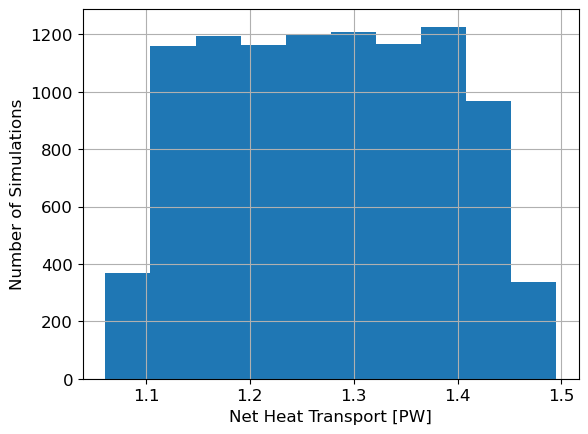

In [86]:
font_size = 12

(transport_df.net_heat_transport/(10**15)).hist()
plt.xlabel('Net Heat Transport [PW]',fontsize=font_size)
plt.ylabel('Number of Simulations',fontsize=font_size)
plt.gca().tick_params(axis='both', which='major', labelsize=font_size)

plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/EN4/Full_Bootstrap_Net_Heat_Transport.png',dpi=300,facecolor='white',bbox_inches='tight')


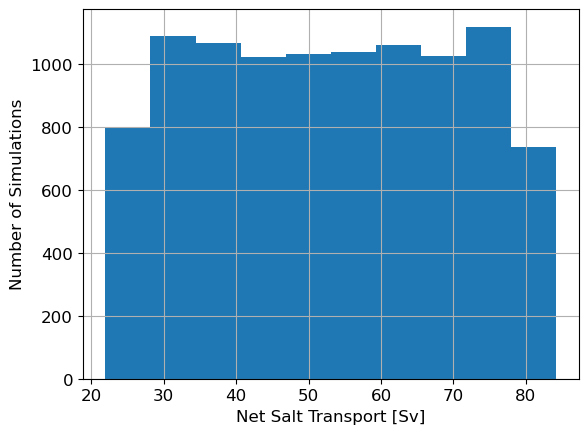

In [87]:
font_size = 12

(transport_df.net_salt_transport/(10**6)).hist()
plt.xlabel('Net Salt Transport [Sv]',fontsize=font_size)
plt.ylabel('Number of Simulations',fontsize=font_size)
plt.gca().tick_params(axis='both', which='major', labelsize=font_size)

plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/EN4/Full_Bootstrap_Net_Salt_Transport.png',dpi=300,facecolor='white',bbox_inches='tight')


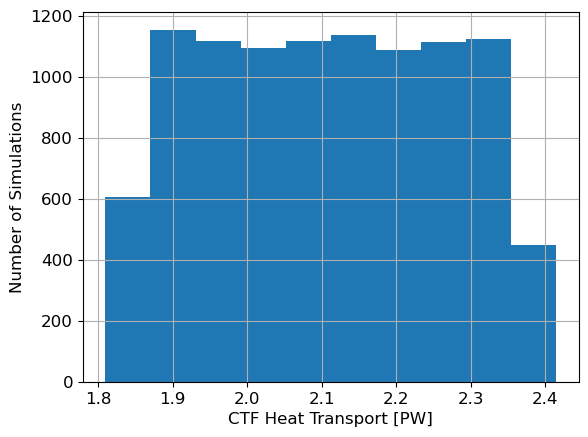

In [88]:
font_size = 12

(transport_df.ctf_heat_transport/(10**15)).hist()
plt.xlabel('CTF Heat Transport [PW]',fontsize=font_size)
plt.ylabel('Number of Simulations',fontsize=font_size)
plt.gca().tick_params(axis='both', which='major', labelsize=font_size)

plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/EN4/Full_Bootstrap_CTF_Heat_Transport.png',dpi=300,facecolor='white',bbox_inches='tight')


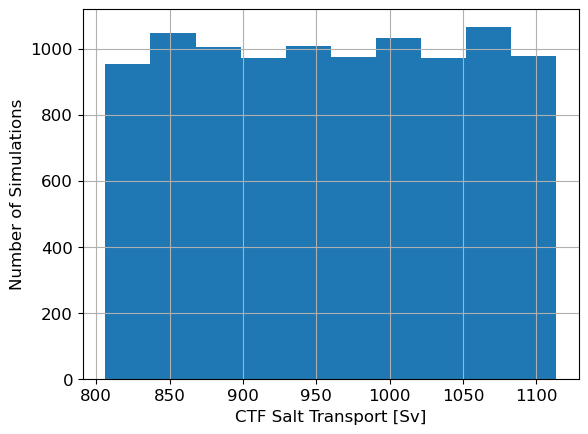

In [89]:
font_size = 12

(transport_df.ctf_salt_transport/(10**6)).hist()
plt.xlabel('CTF Salt Transport [Sv]',fontsize=font_size)
plt.ylabel('Number of Simulations',fontsize=font_size)
plt.gca().tick_params(axis='both', which='major', labelsize=font_size)

plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/EN4/Full_Bootstrap_CTF_Salt_Transport.png',dpi=300,facecolor='white',bbox_inches='tight')
